In [106]:
import torch
import torch.nn as nn
from typing import Tuple, Union, Optional, List
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [66]:
# a utility for calculating running average
class AverageMeter():
    def __init__(self):
        self.num = 0
        self.tot = 0

    def update(self, val: float, sz: float):
        self.num += val*sz
        self.tot += sz

    def calculate(self) -> float:
        return self.num/self.tot

# Problem 2: Implement a Transformer

## Part 2.A

In [67]:
class AttentionHead(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim: the dimension of the input
        # n_hidden: the dimension of the keys, queries, and values

        super().__init__()

        self.W_K = nn.Linear(dim, n_hidden) # W_K weight matrix
        self.W_Q = nn.Linear(dim, n_hidden) # W_Q weight matrix
        self.W_V = nn.Linear(dim, n_hidden) # W_V weight matrix
        self.n_hidden = n_hidden

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing self-attention on x. shape: (Batch x Num_tokens x n_hidden)
        # alpha            the attention weights (after softmax). shape: (B x T x T)
        #

        # TODO: Compute self attention on x.
        #       (1) First project x to the query Q, key K, value V.
        #       (2) Then compute the attention weights alpha as:
        #                  alpha = softmax(QK^T/sqrt(n_hidden))
        #           Make sure to take into account attn_mask such that token i does not attend on token
        #           j if attn_mask[b, i, j] == 0. (Hint, in such a case, what value should you set the weight
        #           to before the softmax so that after the softmax the value is 0?)
        #       (3) The output is a linear combination of the values (weighted by the alphas):
        #                  out = alpha V
        #       (4) return the output and the alpha after the softmax

        # ======= Answer START ========
        # (1) project x to the query Q, key K, value V.
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        # (2) compute the attention weights alpha
        weight = Q @ K.permute(0,2,1) / self.n_hidden**0.5

        if attn_mask is not None:
          attn_mask = attn_mask.bool()
          weight = weight.masked_fill(~attn_mask, -np.inf) # the weight should be -inf

        alpha = nn.functional.softmax(weight, dim=-1)

        # (3) compute the output
        attn_output = alpha @ V

        # ======= Answer  END ========

        return attn_output, alpha

In [68]:
from posixpath import dirname
class MultiHeadedAttention(nn.Module):
    def __init__(self, dim: int, n_hidden: int, num_heads: int):
        # dim: the dimension of the input
        # n_hidden: the hidden dimension for the attention layer
        # num_heads: the number of attention heads
        super().__init__()

        # TODO: set up your parameters for multi-head attention. You should initialize
        #       num_heads attention heads (see nn.ModuleList) as well as a linear layer
        #       that projects the concatenated outputs of each head into dim
        #       (what size should this linear layer be?)

        # ======= Answer START ========
        # initialize num_heads attention heads (see nn.ModuleList)
        self.attn_list = nn.ModuleList([AttentionHead(dim, n_hidden) for i in range(num_heads)])

        # initialize the W_O that projects the concatenated outputs into dim
        self.W_O = nn.Linear(num_heads * n_hidden, dim)
        # ======= Answer  END ========

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing multi-headed self-attention on x.
        #                  shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_output, attn_alphas = None, None

        # TODO: Compute multi-headed attention. Loop through each of your attention heads
        #       and collect the outputs. Concatenate them together along the hidden dimension,
        #       and then project them back into the output dimension (dim). Return both
        #       the final attention outputs as well as the alphas from each head.

        # ======= Answer START ========
        attn_output_list = []
        alpha_list = []

        for attn in self.attn_list:
          attn_output, alpha = attn(x, attn_mask)
          attn_output_list.append(attn_output)
          alpha_list.append(alpha)

        attn_output = self.W_O(torch.cat(attn_output_list, dim=-1))
        attn_alphas = torch.stack(alpha_list).permute(1, 0, 2, 3)

        # ======= Answer END ==========
        return attn_output, attn_alphas

## Part 2.C

In [69]:
# these are already implemented for you!

class FFN(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim       the dimension of the input
        # n_hidden  the width of the linear layer

        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, dim),
        )

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        # x         the input. shape: (B x T x dim)

        # Outputs:
        # out       the output of the feed-forward network: (B x T x dim)
        return self.net(x)

class AttentionResidual(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        super().__init__()
        self.attn = MultiHeadedAttention(dim, attn_dim, num_heads)
        self.ffn = FFN(dim, mlp_dim)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_out, alphas = self.attn(x=x, attn_mask=attn_mask)
        x = attn_out + x
        x = self.ffn(x) + x
        return x, alphas

In [70]:
class Transformer(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        # num_layers the number of attention layers.
        super().__init__()

        # TODO: set up the parameters for the transformer!
        #       You should set up num_layers of AttentionResiduals
        #       nn.ModuleList will be helpful here.

        # ======= Answer START ========
        self.layer = nn.ModuleList([AttentionResidual(dim, attn_dim, mlp_dim, num_heads) for i in range(num_layers)])
        # ======= Answer END ==========

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor, return_attn=False)-> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. Pass this to each of the AttentionResidual layers!
        #                  shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      If return_attn is False, return None. Otherwise return the attention weights
        #                  of each of each of the attention heads for each of the layers.
        #                  shape: (B x Num_layers x Num_heads x T x T)

        # TODO: Implement the transformer forward pass! Pass the input successively through each of the
        # AttentionResidual layers. If return_attn is True, collect the alphas along the way.

        # ======= Answer START ========
        collected_attns = [] if return_attn else None
        for g in self.layer:
          x, alphas = g(x, attn_mask)

          if return_attn:
            collected_attns.append(alphas)

        if return_attn:
            collected_attns = torch.stack(collected_attns, dim=1)

        output = x
        # ======= Answer END ==========

        return output, collected_attns

Test your transformer implementation here

In [71]:
def perform_transformer_test_cases():
    num_tokens = 100
    batch_size = 10
    dim = 64
    num_layers = 4
    num_heads = 2
    dummy_model = Transformer(dim=dim, attn_dim=32, mlp_dim=dim, num_heads=num_heads, num_layers=num_layers).cuda()

    inp = torch.randn(batch_size, num_tokens, dim).cuda()

    # test case 1 regular forward pass
    print("Test Case 1")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None)
        assert alpha is None
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"

    # test case 2 collect attentions
    print("Test Case 2")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None, return_attn=True)
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"
        assert alpha.shape == (batch_size, num_layers, num_heads, num_tokens, num_tokens), f"wrong alpha shape {alpha.shape}"

    # test case 3 with attention mask
    attn_mask = torch.zeros(batch_size, num_tokens, num_tokens).cuda()
    attn_mask[:, torch.arange(num_tokens), torch.arange(num_tokens)] = 1
    attn_mask[:, torch.arange(num_tokens)[1:], torch.arange(num_tokens)[:-1]] = 1

    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=attn_mask, return_attn=True)
        print("Attention mask pattern", attn_mask[0])
        print("Alpha pattern", alpha[0, 0, 0])
        assert torch.all(alpha.permute(1, 2, 0, 3, 4)[:, :, attn_mask == 0] == 0).item()

perform_transformer_test_cases()

Test Case 1
Test Case 2
Attention mask pattern tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]], device='cuda:0')
Alpha pattern tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4893, 0.5107, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4285, 0.5715,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4230, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4806, 0.5194, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6032, 0.3968]],
       device='cuda:0')


## Problem 3: Vision Transformer

## Part 3.A

In [72]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size: int, patch_size: int, nin: int, nout: int):
        # img_size       the width and height of the image. you can assume that
        #                the images will be square
        # patch_size     the width of each square patch. You can assume that
        #                img_size is divisible by patch_size
        # nin            the number of input channels
        # nout           the number of output channels

        super().__init__()
        assert img_size % patch_size == 0

        self.img_size = img_size
        self.num_patches = (img_size // patch_size)**2

        # TODO Set up parameters for the Patch Embedding
        # ======= Answer START ========

        # define the Conv2d and Flatten modules
        self.conv = nn.Conv2d(in_channels=nin, out_channels=nout, kernel_size=patch_size, stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        # ======= Answer END ==========

    def forward(self, x: torch.Tensor):
        # x        the input image. shape: (B, nin, Height, Width)
        #
        # Output
        # out      the patch embeddings for the input. shape: (B, num_patches, nout)


        # TODO: Implement the patch embedding. You want to split up the image into
        # square patches of the given patch size. Then each patch_size x patch_size
        # square should be linearly projected into an embedding of size nout.
        #
        # Hint: Take a look at nn.Conv2d. How can this be used to perform the
        #       patch embedding?

        # ======= Answer START ========
        x_conv = self.conv(x) # shape: [B, nout, img_size // patch_size, img_size // patch_size]
        x_flatten = self.flatten(x_conv) # shape: [B, nout, num_patches]
        out = x_flatten.permute(0, 2, 1) # shape: [B, num_patches, nout]
        # ======= Answer END ==========

        return out

## Part 3.B

In [73]:
class VisionTransformer(nn.Module):
    def __init__(self, n_channels: int, nout: int, img_size: int, patch_size: int, dim: int, attn_dim: int,
                 mlp_dim: int, num_heads: int, num_layers: int):
        # n_channels       number of input image channels
        # nout             desired output dimension
        # img_size         width of the square image
        # patch_size       width of the square patch
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, nin=n_channels, nout=dim)
        self.pos_E = nn.Embedding((img_size//patch_size)**2, dim) # positional embedding matrix

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim)) # learned class embedding
        self.transformer = Transformer(
            dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, nout)
        )

    def forward(self, img: torch.Tensor, return_attn=False) ->Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # img          the input image. shape: (B, nin, img_size, img_size)
        # return_attn  whether to return the attention alphas
        #
        # Outputs
        # out          the output of the vision transformer. shape: (B, nout)
        # alphas       the attention weights for all heads and layers. None if return_attn is False, otherwise
        #              shape: (B, num_layers, num_heads, num_patches + 1, num_patches + 1)

        # generate embeddings
        embs = self.patch_embed(img) # patch embedding
        B, T, _ = embs.shape
        pos_ids = torch.arange(T).expand(B, -1).to(embs.device)
        embs += self.pos_E(pos_ids) # positional embedding

        cls_token = self.cls_token.expand(len(embs), -1, -1)
        x = torch.cat([cls_token, embs], dim=1)

        x, alphas = self.transformer(x, attn_mask=None, return_attn=return_attn)
        out = self.head(x)[:, 0]
        return out, alphas



## Part 3.C

In [74]:
# set up the dataset and dataloader

MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2470, 0.2435, 0.2616]
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])
inv_transform = transforms.Compose([
    transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = 1/np.array(STD)),
    transforms.Normalize(
        mean = -np.array(MEAN),
        std = [ 1., 1., 1. ]),
    transforms.ToPILImage(),
])


train_dataset = torchvision.datasets.CIFAR10(train=True, root='data', transform=img_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10(train=False, root='data', transform=img_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=10)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=10)

100%|██████████| 170498071/170498071 [00:04<00:00, 37890256.93it/s]


Extracting data/cifar-10-python.tar.gz to data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [75]:
# set up the model and optimizer

import torch.optim as optim

model = VisionTransformer(n_channels=3, nout=10, img_size=32, patch_size=4,
                          dim=128, attn_dim=64, mlp_dim=128, num_heads=3, num_layers=6).cuda()

criterion = nn.CrossEntropyLoss()


NUM_EPOCHS = 10
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)



In [76]:
# evaluate the model
def evaluate_cifar_model(model, criterion, val_loader):
    is_train = model.training
    model.eval()
    with torch.no_grad():
        loss_meter, acc_meter = AverageMeter(), AverageMeter()
        for batch in val_loader:
            outputs, _ = model(img)
            loss_meter.update(criterion(outputs, labels).item(), len(img))
            acc = (outputs.argmax(-1) == labels).float().mean().item()
            acc_meter.update(acc, len(img))
    model.train(is_train)
    return loss_meter.calculate(), acc_meter.calculate()

In [14]:
# train the model
import tqdm
for epoch in range(NUM_EPOCHS):  #
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    for img, labels in tqdm.tqdm(train_dataloader):
        img, labels = img.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs, _ = model(img)
        loss = criterion(outputs, labels)
        loss_meter.update(loss.item(), len(img))
        acc = (outputs.argmax(-1) == labels).float().mean().item()
        acc_meter.update(acc, len(img))
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate()}, Acc: {acc_meter.calculate()}")
    if epoch % 10 == 0:
        val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
        print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")

val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")
print('Finished Training')

100%|██████████| 196/196 [00:22<00:00,  8.87it/s]

Train Epoch: 0, Loss: 1.670625510635376, Acc: 0.39186000000953675


Val Epoch: 0, Loss: 1.443329930305481, Acc: 0.5375000238418579


100%|██████████| 196/196 [00:22<00:00,  8.66it/s]


Train Epoch: 1, Loss: 1.3569808107757568, Acc: 0.5141799999809266


100%|██████████| 196/196 [00:22<00:00,  8.88it/s]


Train Epoch: 2, Loss: 1.2226431272888183, Acc: 0.5621800000572205


100%|██████████| 196/196 [00:24<00:00,  8.15it/s]


Train Epoch: 3, Loss: 1.113698412628174, Acc: 0.6012600000190735


100%|██████████| 196/196 [00:21<00:00,  9.08it/s]


Train Epoch: 4, Loss: 0.9987624634170532, Acc: 0.6425999999809265


100%|██████████| 196/196 [00:22<00:00,  8.54it/s]


Train Epoch: 5, Loss: 0.881389510269165, Acc: 0.6862400000190735


100%|██████████| 196/196 [00:21<00:00,  9.17it/s]


Train Epoch: 6, Loss: 0.7352313379573822, Acc: 0.7410000000190735


100%|██████████| 196/196 [00:22<00:00,  8.86it/s]


Train Epoch: 7, Loss: 0.5884382677268982, Acc: 0.7967200000190735


100%|██████████| 196/196 [00:23<00:00,  8.43it/s]


Train Epoch: 8, Loss: 0.4617483802986145, Acc: 0.849040000038147


100%|██████████| 196/196 [00:21<00:00,  8.95it/s]

Train Epoch: 9, Loss: 0.38499923270702363, Acc: 0.8817399999809266


Val Epoch: 9, Loss: 0.2393687218427658, Acc: 0.949999988079071
Finished Training


# Part 3.D

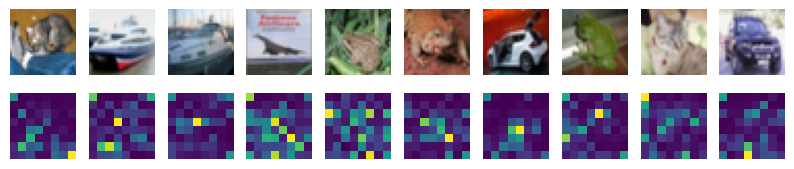

In [15]:
for val_batch in val_dataloader:
    break

model.eval()
with torch.no_grad():
    img, labels = val_batch
    img = img.cuda()
    outputs, attns = model(img, return_attn=True)

fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    flattened_attns = attns.flatten(1,2)[:, :, 0, 1:].mean(1).reshape(-1, 8, 8).cpu().numpy()
    ax[0, i].imshow(inv_transform(img[i]))
    ax[1, i].imshow(flattened_attns[i])
    ax[0, i].axis(False)
    ax[1, i].axis(False)

# Problem 4: Dialogue GPT

In [77]:
!pip install wget

In [78]:
import wget
import os
if not os.path.exists("input.txt"):
    wget.download("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

In [79]:
with open('input.txt', 'r') as f:
    raw_text = f.read()
# for special in ['.', ':', ',']:
#     raw_text = raw_text.replace(special, ' ')
all_dialogues = raw_text.split('\n\n')


In [80]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Part 4.A

In [107]:
def tokenize(s):
  return word_tokenize(s)

class MyTokenizer:
    def __init__(self, raw_text: str):
        # raw_text     contains the text from which we will build our vocabulary

        self.start = '<START>' # token that starts every example
        self.pad = '<PAD>' # token used to pad examples to the same length
        self.unk = '<UNK>' # token used if encountering a word not in our vocabulary

        vocab = np.unique(tokenize(raw_text))
        vocab = np.concatenate([np.array([self.start, self.pad, self.unk]), vocab])

        self.vocab = vocab # array of tokens in order
        self.tok_to_id = {w: i for i, w in enumerate(vocab)} # mapping of token to ID
        self.vocab_size = len(self.vocab) # size of vocabulary

    def encode(self, s: str) -> torch.Tensor:
        # s           input string
        #
        # Output
        # id_tensor   a tensor of token ids, starting with the start token.t


        # TODO: tokenize the input using word_tokenize. Return a tensor
        # of the token ids, starting with the token id for the start token.
        # ============ ANSWER START ===========
        s_tokenized = tokenize(s) # tokenize the input

        # construct the list of token ids
        s_ids = [self.tok_to_id.get(w, self.tok_to_id['<UNK>']) for w in s_tokenized]
        s_ids.insert(0, self.tok_to_id['<START>'])

        id_tensor = torch.tensor(s_ids)
        # ============ ANSWER END =============

        return id_tensor

    def decode(self, toks: torch.Tensor) -> str:
        # toks         a list of token ids
        #
        # Output
        # decoded_str  the token ids decoded back into a string (join with a space)


        # TODO: convert the token ids back to the actual corresponding words.
        # Join the tokens with a space and return the full string
        # ============ ANSWER START ===========
        string = []
        for id in toks:
          w_ids = [w for w, i in self.tok_to_id.items() if i == id]
          string.append(w_ids[0])

        decoded_str = ' '.join(string)
        # ============ ANSWER END =============

        return decoded_str

    def pad_examples(self, tok_list: List[torch.Tensor]) -> torch.Tensor:
        # Pads the tensors to the right with the pad token so that they are the same length.
        #
        # tok_list       a list of tensors containing token ids (maybe of different lengths)
        #
        # Output
        # padded_tokens  shape: (len(tok_list), max length within tok_list)
        return torch.nn.utils.rnn.pad_sequence(tok_list, batch_first=True, padding_value=self.tok_to_id[self.pad])

tok = MyTokenizer(raw_text)

In [108]:
# tokenizer test cases
input_string = 'KING RICHARD III:\nSay that I did all this for love of her.'
enc = tok.encode(input_string)
print(enc)
dec = tok.decode(enc)
print(dec)
assert dec == "<START> KING RICHARD III : Say that I did all this for love of her ."

tensor([    0,  1599,  2188,  1487,   226,  2349, 12831,  1481,  5724,  3327,
        12886,  6880,  8773,  9662,  7689,   224])
<START> KING RICHARD III : Say that I did all this for love of her .


# Part 4.B

In [116]:
class DialogueDataset:
    def __init__(self, tokenizer: MyTokenizer, lines: List[torch.tensor], max_N: int):
        # tokenizer    an instance of MyTokenizer
        # lines        a list of strings. each element in an example in the dataset
        # max_N        the maximum number of tokens allowed per example. More than this will be truncated
        # Note: change 'lines: List[str]' to 'lines: List[torch.tensor]'
        self.lines = lines
        self.tokenizer = tokenizer
        self.max_N = max_N

    def __len__(self) -> int:
        return len(self.lines)

    def __getitem__(self, idx: int) -> torch.Tensor:
        # returns the example at int encoded by the tokenizer
        # truncates the example if it is more than max_N tokens
        return self.tokenizer.encode(self.lines[idx])[:self.max_N]

def collate_fn(examples: List[torch.Tensor]):
    # examples        a batch of tensors containing token ids (maybe of different lengths)
    # Outputs a dictionary containing
    #   input_ids     a single tensor with all of the examples padded (from the right) to the max
    #                 length within the batch. shape:(B, max length within examples)
    #   input_mask    a tensor indicating which tokens are padding and should be ignored. 0 if padding
    #                 and 1 if not. shape: (B, max length within examples)
    new_input_ids = tok.pad_examples(examples)
    attn_mask = torch.ones(new_input_ids.shape)
    attn_mask[new_input_ids == tok.tok_to_id[tok.pad]] = 0
    return {'input_ids': tok.pad_examples(examples), 'input_mask': attn_mask}

ds = DialogueDataset(tok, all_dialogues, max_N=200)
training_dl = torch.utils.data.DataLoader(ds, batch_size=64, collate_fn=collate_fn)

In [115]:
# take a look at an example of an element from the training dataloader
for batch in training_dl:
    print(batch)
    break

{'input_ids': tensor([[   0, 1155,  712,  ...,    1,    1,    1],
        [   0,  326,  226,  ...,    1,    1,    1],
        [   0, 1155,  712,  ...,    1,    1,    1],
        ...,
        [   0, 1739,  226,  ...,    1,    1,    1],
        [   0, 1155, 2391,  ...,    1,    1,    1],
        [   0, 1739,  226,  ...,    1,    1,    1]]), 'input_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])}


## Part 4.C

In [126]:
class DialogueGPT(nn.Module):
    def __init__(self, vocab_size: int, max_N: int, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # vocab_size       size of the vocabulary
        # max_N            maximum number of tokens allowed to appear in 1 example
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.

        super().__init__()

        # TODO: set up the token embedding and positional embeddings
        #       Hint, use nn.Embedding
        # ============ ANSWER START ============
        self.token_embedding = nn.Embedding(vocab_size, dim)
        self.positional_embedding = nn.Embedding(max_N, dim)
        # ============ ANSWER END ==============

        self.transformer = Transformer(
            dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, vocab_size)
        )

    def forward(self, input_ids: torch.Tensor, return_attn=False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # input_ids     a batch of input ids (right padded). shape: (B x T)
        # return_attn   whether to return the attention weights
        #
        # Output
        # out           the logit vector (B x T x V)
        # alphas        the attention weights if return_attn is True. Otherwise None shape: (B, num_layers, num_heads, T, T)

        # TODO: retrieve the token embeddings for the input_ids.
        #       Add to the token embeddings the positional embeddings.
        #       Store the combined embedding in embs
        # ============ ANSWER START ============
        B, T = input_ids.shape
        # get positions of ids
        positions = torch.arange(T, device=input_ids.device).unsqueeze(0).repeat(B, 1)
        token_emb = self.token_embedding(input_ids)
        pos_emb = self.positional_embedding(positions)

        # Store the combined embedding
        embs = token_emb + pos_emb
        # ============ ANSWER END ============

        causal_attn_mask = None

        # TODO: Create the causal attention mask, which should be of size (B, T, T)
        #       Remember that the causal attention mask is lower triangular (all tokens only
        #       depend on themselves and the tokens before them).
        #.      Store the mask in causal_attn_mask
        # Hint: check out torch.tril
        # ============ ANSWER START ============
        causal_attn_mask = torch.tril(torch.ones((B, T, T), device=input_ids.device)).bool()
        # ============ ANSWER END ==============

        x, alphas = self.transformer(embs, attn_mask=causal_attn_mask, return_attn=return_attn)
        out = self.head(x)
        return out, alphas

    def generate(self, input_ids, num_tokens):
        # you can assume batch size 1
        with torch.no_grad():
            for i in range(num_tokens):
                out, _ = self.forward(input_ids)
                new_token = torch.argmax(out[:, [-1]], -1)
                input_ids = torch.cat([input_ids, new_token], dim=1)
        return input_ids


## Part 4.D

In [127]:
class DialogueLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits: torch.Tensor, input_ids: torch.Tensor, inp_mask: torch.Tensor):
        # logits      the logits produced by DialogueGPT. shape: (B x T x V)
        # input_ids   the token ids. shape: (B x T)
        # inp_mask    a 0/1 mask of which tokens are padding tokens and should be ignored. shape: (B x T)

        # TODO: Implement the language model loss. For logits[i], we want to supervise the i+1 token_id
        # with the cross entropy loss. We thus will not supervise the start token (input_ids[0]) or use
        # the last logit vector (logits[-1]). Return the average of the losses for each token in the batch,
        # making sure to ignore tokens corresponding to the padding (use inp_mask).

        logits = logits.transpose(1, 2)
        loss = self.criterion(logits[:, :, :-1], input_ids[:, 1:])
        loss = (loss[inp_mask[:, 1:] == 1]).mean()
        return loss

## Part 4.F

In [128]:
import torch.optim as optim

model = DialogueGPT(vocab_size=tok.vocab_size, max_N=200, dim=128, attn_dim=64, mlp_dim=128, num_heads=3, num_layers=6).cuda()
criterion = DialogueLoss()

NUM_EPOCHS = 80



optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


In [129]:
import tqdm
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    loss_meter = AverageMeter()
    for inp_dict in tqdm.tqdm(training_dl):
        # get the inputs; data is a list of [inputs, labels]
        inp_ids, inp_mask = inp_dict['input_ids'], inp_dict['input_mask']
        inp_ids = inp_ids.cuda()
        inp_mask = inp_mask.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = model(input_ids=inp_ids)
        loss = criterion(outputs, inp_ids, inp_mask)
        loss_meter.update(loss.item(), len(inp_dict['input_ids']))
        loss.backward()
        optimizer.step()
    scheduler.step()

        # print example
    inp = tok.encode("").unsqueeze(0).cuda()
    print(tok.decode(model.generate(inp, 10)[0].cpu()))

    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate():0.4f}, LR: {scheduler.get_last_lr()[0]}")


100%|██████████| 113/113 [00:24<00:00,  4.64it/s]


<START> : : , , , , , , , ,
Train Epoch: 0, Loss: 8.4303, LR: 9.996145181203615e-05


100%|██████████| 113/113 [00:23<00:00,  4.74it/s]


<START> : : , , , , , , , ,
Train Epoch: 1, Loss: 7.0164, LR: 9.98458666866564e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> : : , , , , , , , ,
Train Epoch: 2, Loss: 6.5004, LR: 9.965342284774632e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> : : , I , I , I , I
Train Epoch: 3, Loss: 6.3362, LR: 9.938441702975689e-05


100%|██████████| 113/113 [00:23<00:00,  4.77it/s]


<START> : : I , I , I , and I
Train Epoch: 4, Loss: 6.2417, LR: 9.903926402016153e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING : I , I , I , and the
Train Epoch: 5, Loss: 6.1528, LR: 9.861849601988383e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING : I , I , I 'll , I
Train Epoch: 6, Loss: 6.0647, LR: 9.812276182268236e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING : I 'll , I am , and the
Train Epoch: 7, Loss: 5.9848, LR: 9.755282581475769e-05


100%|██████████| 113/113 [00:23<00:00,  4.74it/s]


<START> KING : I 'll , I am , and the
Train Epoch: 8, Loss: 5.9129, LR: 9.690956679612421e-05


100%|██████████| 113/113 [00:23<00:00,  4.76it/s]


<START> KING : I 'll , I have , and the
Train Epoch: 9, Loss: 5.8470, LR: 9.619397662556433e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING VINCENTIO : I 'll , sir , and a
Train Epoch: 10, Loss: 5.7917, LR: 9.540715869125406e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING VINCENTIO : I 'll , sir , and a
Train Epoch: 11, Loss: 5.7392, LR: 9.455032620941839e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING RICHARD : I 'll be , and you ,
Train Epoch: 12, Loss: 5.6917, LR: 9.362480035363986e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I have , sir , and
Train Epoch: 13, Loss: 5.6498, LR: 9.263200821770461e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I have , sir , and
Train Epoch: 14, Loss: 5.6117, LR: 9.157348061512727e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> KING RICHARD III : I have , sir , sir
Train Epoch: 15, Loss: 5.5763, LR: 9.045084971874738e-05


100%|██████████| 113/113 [00:23<00:00,  4.72it/s]


<START> KING RICHARD III : I have , sir , sir
Train Epoch: 16, Loss: 5.5437, LR: 8.926584654403724e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I have , sir , sir
Train Epoch: 17, Loss: 5.5128, LR: 8.802029828000156e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> DUKE VINCENTIO : I 'll be , sir , and
Train Epoch: 18, Loss: 5.4844, LR: 8.671612547178429e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I 'll be , sir , and
Train Epoch: 19, Loss: 5.4575, LR: 8.535533905932738e-05


100%|██████████| 113/113 [00:23<00:00,  4.81it/s]


<START> DUKE VINCENTIO : I 'll be , sir , and
Train Epoch: 20, Loss: 5.4322, LR: 8.39400372766471e-05


100%|██████████| 113/113 [00:23<00:00,  4.82it/s]


<START> DUKE VINCENTIO : I 'll be , sir , and
Train Epoch: 21, Loss: 5.4079, LR: 8.247240241650919e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I 'll be , sir , I
Train Epoch: 22, Loss: 5.3845, LR: 8.095469746549169e-05


100%|██████████| 113/113 [00:23<00:00,  4.74it/s]


<START> DUKE VINCENTIO : I 'll be , sir , I
Train Epoch: 23, Loss: 5.3619, LR: 7.938926261462365e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> DUKE VINCENTIO : I 'll be , sir , I
Train Epoch: 24, Loss: 5.3401, LR: 7.77785116509801e-05


100%|██████████| 113/113 [00:23<00:00,  4.77it/s]


<START> DUKE VINCENTIO : I am you , sir , sir
Train Epoch: 25, Loss: 5.3194, LR: 7.612492823579744e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING EDWARD IV : I have , sir , sir
Train Epoch: 26, Loss: 5.2997, LR: 7.443106207484775e-05


100%|██████████| 113/113 [00:23<00:00,  4.76it/s]


<START> KING EDWARD IV : I have , sir , sir
Train Epoch: 27, Loss: 5.2804, LR: 7.269952498697733e-05


100%|██████████| 113/113 [00:23<00:00,  4.77it/s]


<START> KING EDWARD IV : I have , sir , sir
Train Epoch: 28, Loss: 5.2615, LR: 7.093298687687139e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> DUKE VINCENTIO : I have a man , sir ,
Train Epoch: 29, Loss: 5.2433, LR: 6.913417161825447e-05


100%|██████████| 113/113 [00:23<00:00,  4.74it/s]


<START> DUKE VINCENTIO : I have a man , sir ,
Train Epoch: 30, Loss: 5.2258, LR: 6.730585285387463e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> DUKE VINCENTIO : I have a man , sir ,
Train Epoch: 31, Loss: 5.2088, LR: 6.545084971874736e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I have a man , sir ,
Train Epoch: 32, Loss: 5.1929, LR: 6.35720224932537e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> DUKE VINCENTIO : I have been , sir , sir
Train Epoch: 33, Loss: 5.1779, LR: 6.167226819279526e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I have been , sir , sir
Train Epoch: 34, Loss: 5.1640, LR: 5.97545161008064e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> DUKE VINCENTIO : I have been , sir , sir
Train Epoch: 35, Loss: 5.1489, LR: 5.782172325201153e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> DUKE VINCENTIO : I have been , sir , sir
Train Epoch: 36, Loss: 5.1337, LR: 5.587686987289187e-05


100%|██████████| 113/113 [00:23<00:00,  4.77it/s]


<START> DUKE VINCENTIO : I have been is a man ,
Train Epoch: 37, Loss: 5.1198, LR: 5.392295478639223e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I have been is a man ,
Train Epoch: 38, Loss: 5.1079, LR: 5.196299078795341e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I have been is a man ,
Train Epoch: 39, Loss: 5.0958, LR: 4.999999999999998e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> DUKE VINCENTIO : I have done , sir , sir
Train Epoch: 40, Loss: 5.0823, LR: 4.8037009212046566e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I have done , sir , sir
Train Epoch: 41, Loss: 5.0693, LR: 4.6077045213607746e-05


100%|██████████| 113/113 [00:23<00:00,  4.81it/s]


<START> DUKE VINCENTIO : I have done , sir , sir
Train Epoch: 42, Loss: 5.0588, LR: 4.4123130127108115e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I have done , sir , sir
Train Epoch: 43, Loss: 5.0498, LR: 4.217827674798846e-05


100%|██████████| 113/113 [00:23<00:00,  4.76it/s]


<START> KING EDWARD IV : I 'll not be a man
Train Epoch: 44, Loss: 5.0410, LR: 4.024548389919358e-05


100%|██████████| 113/113 [00:23<00:00,  4.81it/s]


<START> DUKE VINCENTIO : I have been a man , I
Train Epoch: 45, Loss: 5.0311, LR: 3.832773180720473e-05


100%|██████████| 113/113 [00:23<00:00,  4.81it/s]


<START> DUKE VINCENTIO : I have been a man , I
Train Epoch: 46, Loss: 5.0208, LR: 3.642797750674627e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> DUKE VINCENTIO : I have done . I am a
Train Epoch: 47, Loss: 5.0115, LR: 3.454915028125263e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I have done . I am a
Train Epoch: 48, Loss: 5.0037, LR: 3.269414714612536e-05


100%|██████████| 113/113 [00:23<00:00,  4.80it/s]


<START> DUKE VINCENTIO : I have done . I am you
Train Epoch: 49, Loss: 4.9972, LR: 3.086582838174551e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> DUKE VINCENTIO : I have been so . I am
Train Epoch: 50, Loss: 4.9918, LR: 2.9067013123128613e-05


100%|██████████| 113/113 [00:23<00:00,  4.73it/s]


<START> DUKE VINCENTIO : I have been so . I am
Train Epoch: 51, Loss: 4.9867, LR: 2.7300475013022666e-05


100%|██████████| 113/113 [00:23<00:00,  4.76it/s]


<START> DUKE VINCENTIO : I have been so . I am
Train Epoch: 52, Loss: 4.9808, LR: 2.556893792515225e-05


100%|██████████| 113/113 [00:23<00:00,  4.77it/s]


<START> DUKE VINCENTIO : I have been so . I am
Train Epoch: 53, Loss: 4.9741, LR: 2.3875071764202563e-05


100%|██████████| 113/113 [00:23<00:00,  4.75it/s]


<START> DUKE VINCENTIO : I 'll be : I 'll be
Train Epoch: 54, Loss: 4.9673, LR: 2.222148834901989e-05


100%|██████████| 113/113 [00:23<00:00,  4.76it/s]


<START> DUKE VINCENTIO : I 'll be : I 'll be
Train Epoch: 55, Loss: 4.9610, LR: 2.0610737385376352e-05


100%|██████████| 113/113 [00:23<00:00,  4.77it/s]


<START> DUKE VINCENTIO : I 'll be : I 'll be
Train Epoch: 56, Loss: 4.9556, LR: 1.9045302534508318e-05


100%|██████████| 113/113 [00:23<00:00,  4.77it/s]


<START> DUKE VINCENTIO : I have been so . I am
Train Epoch: 57, Loss: 4.9511, LR: 1.7527597583490826e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> DUKE VINCENTIO : I have been a man , I
Train Epoch: 58, Loss: 4.9474, LR: 1.6059962723352925e-05


100%|██████████| 113/113 [00:23<00:00,  4.73it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 59, Loss: 4.9438, LR: 1.4644660940672629e-05


100%|██████████| 113/113 [00:23<00:00,  4.76it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 60, Loss: 4.9402, LR: 1.3283874528215718e-05


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 61, Loss: 4.9363, LR: 1.1979701719998453e-05


100%|██████████| 113/113 [00:23<00:00,  4.81it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 62, Loss: 4.9323, LR: 1.0734153455962748e-05


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 63, Loss: 4.9285, LR: 9.549150281252633e-06


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 64, Loss: 4.9250, LR: 8.426519384872749e-06


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 65, Loss: 4.9217, LR: 7.3679917822953905e-06


100%|██████████| 113/113 [00:23<00:00,  4.74it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 66, Loss: 4.9188, LR: 6.375199646360152e-06


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 67, Loss: 4.9162, LR: 5.44967379058161e-06


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 68, Loss: 4.9138, LR: 4.592841308745932e-06


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 69, Loss: 4.9118, LR: 3.806023374435663e-06


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 70, Loss: 4.9100, LR: 3.0904332038757918e-06


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 71, Loss: 4.9084, LR: 2.447174185242323e-06


100%|██████████| 113/113 [00:23<00:00,  4.75it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 72, Loss: 4.9070, LR: 1.8772381773176413e-06


100%|██████████| 113/113 [00:23<00:00,  4.73it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 73, Loss: 4.9059, LR: 1.381503980116172e-06


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 74, Loss: 4.9049, LR: 9.607359798384783e-07


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 75, Loss: 4.9041, LR: 6.155829702431169e-07


100%|██████████| 113/113 [00:23<00:00,  4.78it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 76, Loss: 4.9034, LR: 3.4657715225368527e-07


100%|██████████| 113/113 [00:23<00:00,  4.77it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 77, Loss: 4.9029, LR: 1.5413331334360177e-07


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 78, Loss: 4.9026, LR: 3.854818796385494e-08


100%|██████████| 113/113 [00:23<00:00,  4.79it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 79, Loss: 4.9024, LR: 0.0


## Part 4.G

In [130]:
inp = tok.encode("").unsqueeze(0).cuda()
print(tok.decode(model.generate(inp, 50)[0].cpu()))

<START> KING RICHARD III : I am I am I am a man . Come , I am a man , I am a king , I have you , I 'll be a king , I am a man , I 'll be : And I will not be a
